# Imports

In [7]:
import os 
import sys
import pandas as pd
import psycopg2 
from dotenv import load_dotenv
from sqlalchemy import create_engine

In [8]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [9]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0,parent_dir)

In [10]:
from importlib import reload
import scripts.data_loader, scripts.clean_and_transform, scripts.analysis_1, scripts.visualization, scripts.analysis_2, scripts.analysis_3
reload(scripts.data_loader)
reload(scripts.clean_and_transform)
reload(scripts.analysis_1)
reload(scripts.analysis_2)
reload(scripts.visualization)
reload(scripts.analysis_3)

<module 'scripts.analysis_3' from 'c:\\ML and DS Files\\Kifiya AI\\Kaim-week-2\\scripts\\analysis_3.py'>

In [11]:
from scripts.data_loader import DataLoader, LoadSqlData
from scripts.clean_and_transform import DropNullRows, NullValueFiller, DropUndefined
from scripts.analysis_1 import UserSessionAggregator, DataDescriber, VariableTransformer, MetricsAnalyzer, DispersionAnalyzer, PCAAnalyzer, HandsetAnalysis
from scripts.analysis_2 import TelecomEngagementAnalysis
from scripts.analysis_3 import TelecomAnalysis, SatisfactionAnalysis, PostgreSQLExporter
from scripts.visualization import UnivariateAnalyzer, BivariateAnalyzer, CorrelationAnalyzer

# Load data from postgreSQL

In [12]:
# Define your SQL query
query = "SELECT * FROM xdr_data"
# Create an instance of the LoadSqlData class
data_loader = LoadSqlData(query)
# Load data using psycopg2
data= data_loader.load_data_using_sqlalchemy()
data.head()

Sucessfully Loaded


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


# Clean the data

In [13]:
data.shape

(150001, 55)

In [14]:
# Drop  undefined values from Handset Type
drop_undefined = DropUndefined(data)
data = drop_undefined.DeleteUndefined(column='Handset Type', value='undefined')

Sucessfully droped undefined columns


In [15]:
# drop null rows for the follwing columns
# Bearer Id, Start, End, IMSI, MSISDN/Number, IMEI,Last Location Name, Handset Manufacturer, Handset Type
col_1 = ['Bearer Id', 'Start', 'End', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Handset Manufacturer', 'Handset Type']
dropper = DropNullRows(columns_to_check=col_1)

# Drop rows where the specified column has null values
data = dropper.drop_if_null(data)

Sucessfuly dropped null rows from ['Bearer Id', 'Start', 'End', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Handset Manufacturer', 'Handset Type']


In [16]:
null_columns = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 
           'DL TP < 50 Kbps (%)','50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 
           'UL TP < 10 Kbps (%)','10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
            'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B',
            'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B',
            'Nb of sec with 6250B < Vol UL < 37500B','Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B']


In [17]:
# Numerical null values are filled based on the outlier and normal distribution
# Initialize the NullValueFiller class
filler = NullValueFiller(data, null_columns)
    
# Fill null values based on mean/median decision
filler.fill_nulls()

Column 'Avg RTT DL (ms)': Filled null values with median.
Column 'Avg RTT UL (ms)': Filled null values with median.
Column 'TCP DL Retrans. Vol (Bytes)': Filled null values with median.
Column 'TCP UL Retrans. Vol (Bytes)': Filled null values with median.
Column 'DL TP < 50 Kbps (%)': Filled null values with median.
Column '50 Kbps < DL TP < 250 Kbps (%)': Filled null values with median.
Column '250 Kbps < DL TP < 1 Mbps (%)': Filled null values with median.
Column 'DL TP > 1 Mbps (%)': Filled null values with median.
Column 'UL TP < 10 Kbps (%)': Filled null values with median.
Column '10 Kbps < UL TP < 50 Kbps (%)': Filled null values with median.
Column '50 Kbps < UL TP < 300 Kbps (%)': Filled null values with median.
Column 'UL TP > 300 Kbps (%)': Filled null values with median.
Column 'HTTP DL (Bytes)': Filled null values with median.
Column 'HTTP UL (Bytes)': Filled null values with median.
Column 'Nb of sec with 125000B < Vol DL': Filled null values with median.
Column 'Nb of se

In [18]:
data["Start"] = pd.to_datetime(data["Start"])
data["End"] = pd.to_datetime(data["End"])

In [19]:
null_counts = data.isnull().sum()
if null_counts.sum() > 0:
    print('Null value present please check the dataframe')
else:
    print('All columns are not null')

All columns are not null


# Task 3

In [20]:
telecom_analysis = TelecomAnalysis(data)
# Preprocess data calculate the average
telecom_analysis.preprocess_data()

In [21]:
# Task 3 1: Aggregate metrics per customer
aggregated_data = telecom_analysis.aggregate_per_customer()
print("Aggregated Data:\n", aggregated_data.head())

Aggregated Data:
    MSISDN/Number  Avg TCP Retransmission  Avg RTT  \
0   3.360100e+10               638552.50    23.00   
1   3.360100e+10               638552.50    15.50   
2   3.360101e+10                22580.00    42.00   
3   3.360101e+10              5004692.25    29.75   
4   3.360101e+10               331413.25    18.50   

                     Handset Type  Avg Throughput  
0  Huawei P20 Lite Huawei Nova 3E            38.0  
1          Apple iPhone 7 (A1778)            49.5  
2         Apple iPhone 5S (A1457)           124.0  
3         Apple iPhone Se (A1723)         14211.0  
4        Samsung Galaxy A8 (2018)          1977.0  


In [22]:
# Task 3.2: Compute top, bottom, and most frequent for metrics
for metric in ['TCP Retransmission', 'RTT', 'Throughput']:
    top_10, bottom_10, frequent = telecom_analysis.compute_top_bottom_frequent(metric)
    print(f"Top 10 {metric}: {top_10}")
    print(f"Bottom 10 {metric}: {bottom_10}")
    print(f"Most Frequent {metric}: {frequent}")

Top 10 TCP Retransmission: [4.25465964e+09 4.26017414e+09 4.26161604e+09 4.26864735e+09
 4.27549171e+09 4.28812086e+09 4.29146495e+09 4.29443196e+09
 4.30147744e+09 4.34411565e+09]
Bottom 10 TCP Retransmission: [ 86.  97. 106. 108. 113. 128. 129. 134. 143. 173.]
Most Frequent TCP Retransmission: [638552.5, 618332.5, 22844.0, 618368.5, 21552.0, 618356.5, 21606.0, 24174.0, 22832.0, 619698.5]
Top 10 RTT: [10490.  12369.  12694.  12857.5 12961.  13150.  13639.  27424.  32320.5
 48462. ]
Bottom 10 RTT: [0.  0.  0.  0.  1.  2.  2.  2.5 3.  3. ]
Most Frequent RTT: [25.0, 14.5, 19.5, 19.0, 20.0, 15.0, 14.0, 24.5, 15.5, 20.5]
Top 10 Throughput: [132862.  134696.  137026.  138102.5 138576.  140572.  141965.5 150273.
 156622.  191131. ]
Bottom 10 Throughput: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Most Frequent Throughput: [31.5, 7.5, 48.5, 45.0, 49.0, 48.0, 44.5, 49.5, 46.5, 44.0]


In [23]:
# Task 3.3: Average Distribution analysis
throughput_distribution = telecom_analysis.distribution_analysis('Throughput', 'Handset Type')
print("Throughput Distribution:\n", throughput_distribution.head())

tcp_distribution = telecom_analysis.distribution_analysis('TCP Retransmission', 'Handset Type')
print("TCP Retransmission Distribution:\n", tcp_distribution.head())

Throughput Distribution:
                    Handset Type    Throughput
319            Huawei B715S-23C  54497.115385
701     New-Bund Technol. Mix 2  52605.500000
570                      Lg G6+  50067.500000
1387  Zyxel Communicat. Sbg3600  48675.500000
463              Huawei Y9 2019  45869.500000
TCP Retransmission Distribution:
                             Handset Type  TCP Retransmission
581                           Lg Lg-H635         905079953.5
322                      Huawei Bln-Al10         329174592.0
140  Asustek Asus Zenfone Selfie Zd551Kl         321658306.0
969      Samsung Galaxy Tab S3 (Sm-T825)         202648649.8
343                     Huawei E5776S-32         164643147.9


In [24]:
# Task 3.4: K-means clustering
features = ['TCP Retransmission', 'RTT', 'Throughput']
cluster_data, cluster_centers = telecom_analysis.kmeans_clustering(features)
print("Cluster Data:\n", cluster_data.head())
print("Cluster Centers:\n", cluster_centers)

Cluster Data:
    MSISDN/Number  Cluster
0   3.366496e+10        0
1   3.368185e+10        0
2   3.376063e+10        0
4   3.369980e+10        0
6   3.366537e+10        0
Cluster Centers:
 [[4.06700418e+06 5.57217476e+01 7.61541803e+03]
 [1.20325630e+09 8.50409836e+01 3.31535574e+04]
 [3.13128228e+09 7.49000000e+01 3.59612156e+04]]


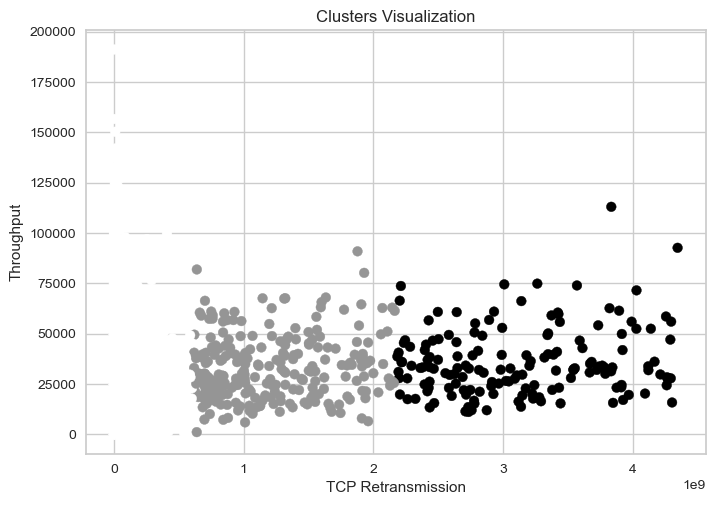

In [25]:
import matplotlib.pyplot as plt
# Visualize clusters
plt.scatter(telecom_analysis.data['TCP Retransmission'], telecom_analysis.data['Throughput'], c=telecom_analysis.data['Cluster'])
plt.title("Clusters Visualization")
plt.xlabel("TCP Retransmission")
plt.ylabel("Throughput")
plt.show()


# Task 4 Satisfaction Analysis

In [26]:
# Satisfaction Analysis
satisfaction_analysis = SatisfactionAnalysis(telecom_analysis.data, cluster_centers)
satisfaction_analysis.assign_scores()

top_10_satisfied = satisfaction_analysis.calculate_satisfaction()
print("Top 10 Satisfied Customers:\n", top_10_satisfied)

Top 10 Satisfied Customers:
            Bearer Id               Start  Start ms                 End  \
34645   1.304243e+19 2019-04-25 00:09:00     100.0 2019-04-26 00:09:00   
140813  7.277826e+18 2019-04-29 03:44:00     807.0 2019-04-30 03:44:00   
77979   7.277826e+18 2019-04-27 02:55:00     378.0 2019-04-28 02:52:00   
135678  1.304243e+19 2019-04-29 00:07:00     411.0 2019-04-30 00:07:00   
3782    7.277826e+18 2019-04-24 04:42:00     318.0 2019-04-25 04:42:00   
119684  1.304243e+19 2019-04-28 03:11:00     319.0 2019-04-29 03:11:00   
39637   7.277826e+18 2019-04-25 03:33:00      22.0 2019-04-26 01:18:00   
59016   7.277826e+18 2019-04-26 01:25:00     313.0 2019-04-27 01:25:00   
76990   1.304243e+19 2019-04-27 01:34:00     550.0 2019-04-28 01:34:00   
41209   1.304243e+19 2019-04-25 04:28:00     900.0 2019-04-26 04:28:00   

        End ms  Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
34645     57.0    86399.0  2.082015e+14   3.366045e+10  8.637690e+13   
140813   701

In [27]:
top_10_satisfied.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 34645 to 41209
Data columns (total 62 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Bearer Id                                 10 non-null     float64       
 1   Start                                     10 non-null     datetime64[ns]
 2   Start ms                                  10 non-null     float64       
 3   End                                       10 non-null     datetime64[ns]
 4   End ms                                    10 non-null     float64       
 5   Dur. (ms)                                 10 non-null     float64       
 6   IMSI                                      10 non-null     float64       
 7   MSISDN/Number                             10 non-null     float64       
 8   IMEI                                      10 non-null     float64       
 9   Last Location Name              

In [28]:
# regression model
regression_model = satisfaction_analysis.regression_model()
print("Regression Model Coefficients:\n", regression_model.coef_)

Regression Model Coefficients:
 [0.5 0.5]


In [29]:
#  k-means (k=2) on the engagement & the experience score. 
score_clusters, score_cluster_centers = satisfaction_analysis.kmeans_on_scores(n_clusters=2)
print("Score Clusters:\n", score_clusters.head())

Score Clusters:
    MSISDN/Number  Score Cluster
0   3.366496e+10              0
1   3.368185e+10              0
2   3.376063e+10              0
4   3.369980e+10              0
6   3.366537e+10              0


In [30]:
# Aggregate the average satisfaction & experience score per cluster
aggregated_scores = satisfaction_analysis.aggregate_scores_per_cluster()
print("Aggregated Scores per Cluster:\n", aggregated_scores)

Aggregated Scores per Cluster:
    Score Cluster  Satisfaction Score  Experience Score
0              0        7.034253e+06      7.034253e+06
1              1        2.588539e+09      2.588539e+09


In [31]:
# Export to PostgreSQL
exporter = PostgreSQLExporter()
exporter.create_table(table_name='Top_10_Exported')

In [32]:
exporter.export_dataframe(table_name='Top_10_Exported', dataframe=top_10_satisfied)

Prepared data tuples for insertion into table 'Top_10_Exported': [(208201547012294.0, 4340048647.651831, 4340048647.651831, 4340048647.651831), (208201716751685.0, 4297410434.826333, 4297410434.826333, 4297410434.826333), (208201715804654.0, 4290364961.091431, 4290364961.091431, 4290364961.091431), (208201716761234.0, 4287397945.86627, 4287397945.86627, 4287397945.86627), (208201715810548.0, 4284053856.000252, 4284053856.000252, 4284053856.000252)]


In [33]:
exporter.close_connection()

In [7]:
#versions check for requirements and installed packages
#%pip list
